# STN-30p Drainage Basins + Riverine Ba classification

* This notebook shows how I worked with STN-30p hydrological records from Dec 12th to 15th.
* Modified on 2015/05/06 for sediment load issues.

# Import Modules and Tools

In [1]:
import sys
sys.path.insert(0, '_libs/')

In [2]:
import glob
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from __future__ import division
from __future__ import print_function
from mpl_toolkits.basemap import cm
% matplotlib inline

In [3]:
reload(Nts)

<module 'NEMO_tools' from '_libs/NEMO_tools.pyc'>

In [4]:
def find_inland(lon, lat):
    '''
    Identify if data points are located in land
    Based on Basemap's GSHHS dataset
    '''
    from mpl_toolkits.basemap import Basemap
    from matplotlib.path import Path
    result = np.empty(lon.shape)
    proj = Basemap(projection='cyl', resolution='l')
    for i in range(np.size(lon, 0)):
        x, y = proj(lon[i, :], lat[i, :])
        locations = np.c_[x, y]
        polygons = [Path(p.boundary) for p in proj.landpolygons]
        row_result = np.zeros(len(locations), dtype=bool) 
        for polygon in polygons:
            row_result += np.array(polygon.contains_points(locations))
        result[i, :] = row_result
    return result

# Drainage Basin Map

## STN-30p classification of drainage basins

I used STN-30p to classify drainage basins. It is a 0.5×0.5 global grided dataset includes:

* Basin id and attributes (overall 6152 different basins with 15 attributes, I used the feature 'SeaName' and 'ClimateZone' to classify);
* Flow accumulation grid or upstream area grid [$km^2$];
* Flow direction grid;
* Distance [$km$] to the outlet of river basins;
* Mainstem length [$km$] grid;
* Strahler stream order grid.
* Adjusted elevation [$m$] grid
* Slope [$deg$] along the STN-30p grid

I get the data from *University of New Hampshire, Water Systems Research Group, 
<a href='http://www.grdc.sr.unh.edu/html/Data/index.html'>Composite Runoff Fields v1.0</a>*.

I also found another version(?) of STN-30p in *U.S. Oak Ridge National Laboratory, DAAC* (<a href='http://daac.ornl.gov/ISLSCP_II/guides/river_routing_stn_xdeg.html'>here</a>), but it do not looks well.

### How I read it

I read the data and select the drainage basins in Arctic by MATLAB and save the result, now we can use the \*.mat file.

This is how I read the file in MATLAB (write Python in this way is much slower):

```matlab
clear all
close all
%% Import data
% basin id
data=importdata('basin.grd');
data=flipud(data); data(data<0)=NaN; [M, N]=size(data);
% lat/lon
res=0.5;
bounding_lat=-55.5;
[longitude, latitude]=meshgrid(-180:res:(-180+res*(N-1)), bounding_lat:res:(bounding_lat+res*(M-1)));
[hit, text, ~]=xlsread('basins.xlsx');
%% Select Arctic Basins
% allocate
Arctic_LCT=zeros([M, N]);
Arctic_LCT(Arctic_LCT==0)=NaN;
% main
for i=1:M
    for j=1:N
        temp=data(i, j);
        if ~isnan(data(i, j))
            BasinLat=latitude(i, j);
            SeaName=char(text(temp+1, 9));
            ClimateZone=hit(temp, 11);
            if (ClimateZone==1) && (BasinLat > 45) % <----- Make sure that it is in Arctic
                switch SeaName
                    case 'Arctic Archipelago'
                        Arctic_LCT(i, j)=1;
                    case 'Arctic subocean'
                        Arctic_LCT(i, j)=2;
                    case 'Baffin Bay'
                        Arctic_LCT(i, j)=3;
                    case 'Barents Sea'
                        Arctic_LCT(i, j)=4;
                    case 'Beaufort Sea'
                        Arctic_LCT(i, j)=5;
                    case 'Bering Strait'
                        Arctic_LCT(i, j)=6;
                    case 'Chukchi Sea'
                        Arctic_LCT(i, j)=7;
                    case 'East Siberian Sea'
                        Arctic_LCT(i, j)=8;
                    case 'Foxe Basin'
                        Arctic_LCT(i, j)=9;
                    case 'Hudson Bay'
                        Arctic_LCT(i, j)=10;
                    case 'Hudson Strait'
                        Arctic_LCT(i, j)=11;
                    case 'Kara Sea'
                        Arctic_LCT(i, j)=12;
                    case 'Laptev Sea'
                        Arctic_LCT(i, j)=13;
                    case 'Norwegian Sea'
                        Arctic_LCT(i, j)=14;
                    case 'Ob Internal Basins'
                        Arctic_LCT(i, j)=15;
                    case 'South Greenland'
                        Arctic_LCT(i, j)=16;
                    case 'Greenland Sea'
                        Arctic_LCT(i, j)=17;
               end
            end
        end
    end
end
%% Simple Visualize
load coast
Handle=pcolor(longitude, latitude, Arctic_LCT); set(Handle, 'LineStyle', 'none')
hold on
plot(long, lat, 'Color', 'k', 'linewidth', 1)
%% Save
save STN-30p Arctic_LCT longitude latitude
```

### Visualization

In [5]:
STN_name=glob.glob('_data/Samples/STN-30p/STN-30p.mat')
print("found file: \n{}".format(STN_name))
STN_obj=scipy.io.loadmat(STN_name[0])

found file: 
['_data/Samples/STN-30p/STN-30p.mat']


In [6]:
basin_id=STN_obj['Arctic_LCT']
latitude=STN_obj['latitude']
longitude=STN_obj['longitude']

There is a new function on NEM0_tools that can plot the data

In [7]:
regions=["Arctic Archipelago", \
        "Arctic subocean",    \
        "Baffin Bay",         \
        "Barents Sea",        \
        "Beaufort Sea",       \
        "Bering Strait",      \
        "Chukchi Sea",        \
        "East Siberian Sea",  \
        "Foxe Basin",         \
        "Hudson Bay",         \
        "Hudson Strait",      \
        "Kara Sea",           \
        "Laptev Sea",         \
        "Norwegian Sea",      \
        "Ob Internal Basins", \
        "South Greenland Sea",\
        "Greenland Sea"]

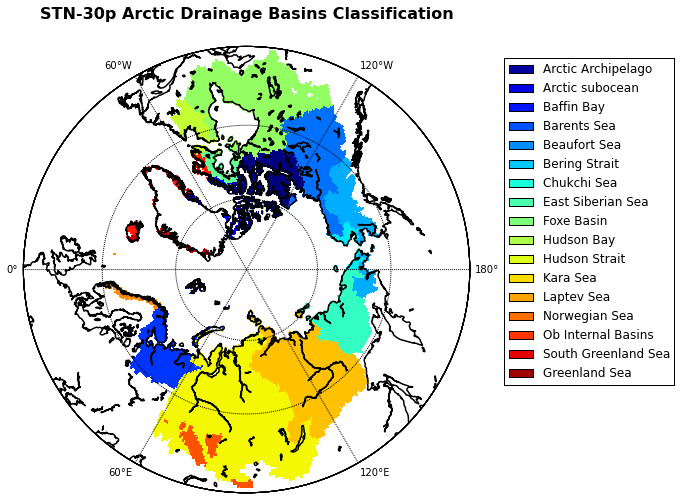

In [8]:
CMap=plt.cm.jet #cm.GMT_seis_r
var_name='Basin Classification'
clev=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
basin_id_masked=np.ma.masked_where(np.isnan(basin_id), basin_id)
#
fig, ax, proj = Nts.plot_Arctic_LandCover(longitude, latitude, 45, basin_id_masked, clev, regions, CMap, var_name)
#
parallels=np.arange(-90, 90, 15)
meridians=np.arange(0, 360, 60)
proj.drawparallels(parallels, labels=[0, 0, 0, 0], latmax=90)
proj.drawmeridians(meridians, labels=[0, 0, 0, 0], latmax=90)
#    
title='STN-30p Arctic Drainage Basins Classification'
ax.set_title(title, fontsize=16, fontweight='bold', y=1.05)
fig.set_size_inches(8, 8)
fig.canvas.draw()

### Classify river run-off

*[R. B. Larmmers, J. Geophys. Res., 2001]* defined the runoff in Arctic, but I don't have the data, (I only have a plot in his paper). 

So here is the uncommon way to get the data (Except email the author, this is the best way in my mind.):

* I print the figure above, and draw the figure to make it similar to the original figure in *[Larmmers, 2001]*;
* I draw the longitude and latitude on the same frame;
* I read all three figure (RGB color --> data) and longitude, latitude, runoff build a relationship;
* bin the longitude, latitude, runoff on xy grid;
* filter the noise (a very good MATLAB script), get the data.

Here is the figure I used as a reference *[Larmmers, 2001]:*

> Pan-Arctic river system drainage organized by sea boundaries

<img src="_figures/Lammers_Bain_map.png" width=500 align="left"/>

In [9]:
rf_name=glob.glob('_data/Samples/STN-30p/runoff_id_modified.mat')
print("found file: \n{}".format(rf_name[0]))
rf_obj=scipy.io.loadmat(rf_name[0])

found file: 
_data/Samples/STN-30p/runoff_id_modified.mat


In [10]:
rf_id=rf_obj['rf_id']
rf_lon=rf_obj['lon']
rf_lat=rf_obj['lat']

In [11]:
rf_id[rf_id==0]=np.nan # 0 is Central Arctic
rf_id[rf_id==2]=np.nan # 2 is subocean

In [12]:
regions=["Arctic Archipelago", \
        "Baffin Bay",         \
        "Barents Sea",        \
        "Beaufort Sea",       \
        "Bering Strait",      \
        "Chukchi Sea",        \
        "East Siberian Sea",  \
        "Foxe Basin",         \
        "Hudson Bay",         \
        "Hudson Strait",      \
        "Kara Sea",           \
        "Laptev Sea",         \
        "Norwegian Sea",      \
        "Ob Internal Basins", \
        "South Greenland Sea",\
        "Greenland Sea"]

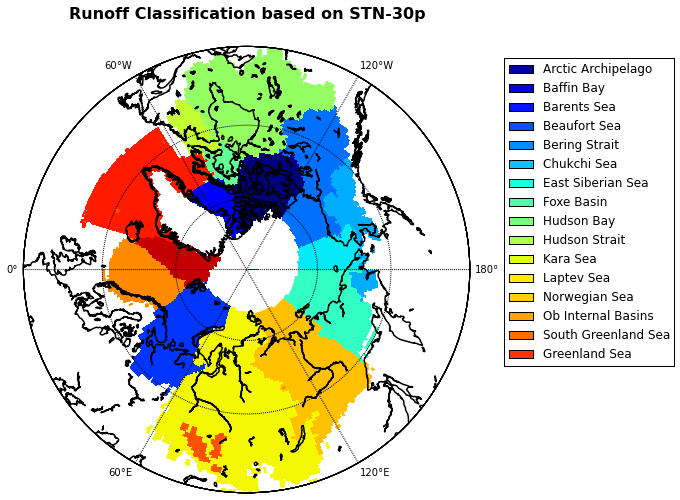

In [14]:
CMap=plt.cm.jet #cm.GMT_seis_r
var_name='Runoff Classification'
clev=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 12.5, 13, 14, 15, 16, 17, 18]
rf_id_masked=np.ma.masked_where(np.isnan(rf_id), rf_id)
#
fig, ax, proj = Nts.plot_Arctic_LandCover(rf_lon, rf_lat, 45, rf_id_masked, clev, regions, CMap, var_name)
#
parallels=np.arange(-90, 90, 15)
meridians=np.arange(0, 360, 60)
proj.drawparallels(parallels, labels=[0, 0, 0, 0], latmax=90)
proj.drawmeridians(meridians, labels=[0, 0, 0, 0], latmax=90)
#    
title='Runoff Classification based on STN-30p'
ax.set_title(title, fontsize=16, fontweight='bold', y=1.05)
fig.set_size_inches(8, 8)
fig.canvas.draw()

# Spatial distribution of riverine Ba 

*Christopher Guay - Barium as a Tracer of Arctic Halocline and River Waters*

<img src="_figures/discharge_sed_table.png" width=650 align="left"/>

**Calculating Sed. load/discharge**

<table align="left">
<tr>
<th>Mackenzie</th>
<th>Yenisey</th>
<th>Ob'</th>
<th>Lena</th>
<th>S.Dvina</th>
<th>Pechora</th>
<th>Kolyma</th>
<th>Khatabga</th>
<th>Indigirka</th>
<th>Pyasina</th>
</tr>
<tr>
<td>14.889</td>
<td>0.73</td>
<td>1.301</td>
<td>0.731</td>
<td>1.331</td>
<td>1.81</td>
<td>2.69</td>
<td>n/a</td>
<td>9.0</td>
<td>n/a</td>
</tr>
</table>

**The locations these rivers**

<img src="_figures/Arctic_rivers.png" width=650 align="left"/>

* group1 = Ob' + Pechora + S. Dvina <--------------------- ~1.3
* group2 = Lena + Pyasina(?) + Khatanga(?) + Yenisey <---- ~0.7
* group3 = Kolyma + Indigirka <---------------------------- 2.7~9
* group4 = Mackenzie <------------------------------------ 15

# Modifying drainge basin classification

In [15]:
rf_id.shape

(90L, 720L)

In [16]:
for i in range(90):
    for j in range(720):
        if (rf_id[i, j]==12) & (rf_lon[i, j]>78.5):
            rf_id[i, j]=12.5

**Delete points in land**

In [17]:
hit = find_inland(rf_lon, rf_lat)
rf_id[hit==1]=np.nan

## Remap on ORCA2 2deg grid

In [18]:
coordinate_name=glob.glob('_data/NEMO/ORCA2_INPUT/coordinates*.nc')
print("found file: \n{}".format(coordinate_name))
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

found file: 
['_data/NEMO/ORCA2_INPUT\\coordinates.nc']


In [19]:
rf_id_interp=Nts.reporj_NEMOgrid(rf_lon, rf_lat, rf_id, nav_lon, nav_lat, method='nearest')

In [29]:
regions=["Arctic Archipelago", \
        "Baffin Bay",         \
        "Barents Sea",        \
        "Beaufort Sea",       \
        "Bering Strait",      \
        "Chukchi Sea",        \
        "East Siberian Sea",  \
        "Foxe Basin",         \
        "Hudson Bay",         \
        "Hudson Strait",      \
        "Kara Sea (Ob')",           \
        "Kara Sea (Lena)",   \
        "Laptev Sea",  \
        "Norwegian Sea",      \
        "South Greenland Sea",\
        "Greenland Sea"]

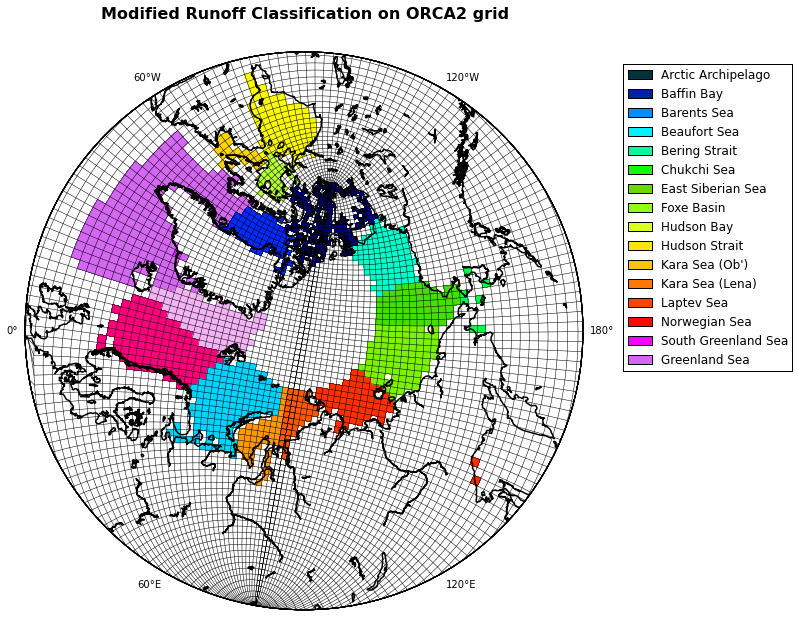

In [30]:
CMap=plt.cm.gist_ncar
var_name='Ba Classification'
clev=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 12.5, 13, 14, 15, 17, 18]
rf_id_interp_masked=np.ma.masked_where(np.isnan(rf_id_interp), rf_id_interp)
#
fig, ax, proj = Nts.plot_Arctic_LandCover(nav_lon, nav_lat, 50, rf_id_interp_masked, clev, regions, CMap, var_name)
#
title='Modified Runoff Classification on ORCA2 grid'
ax.set_title(title, fontsize=16, fontweight='bold', y=1.05)
fig.set_size_inches(10, 10)
#
x, y=proj(nav_lon, nav_lat)
proj.plot(x.T, y.T, color='k', linewidth=0.5)
proj.plot(x, y, color='k', linewidth=0.5)
fig.canvas.draw()

## Define "groups"

In [31]:
rf_Ba_group = np.zeros(rf_id_interp.shape)

rf_Ba_group[rf_id_interp==4]=1
rf_Ba_group[rf_id_interp==12]=1
rf_Ba_group[rf_id_interp==14]=1

rf_Ba_group[rf_id_interp==12.5]=2
rf_Ba_group[rf_id_interp==13]=2

rf_Ba_group[rf_id_interp==7]=3
rf_Ba_group[rf_id_interp==8]=3

rf_Ba_group[rf_id_interp==5]=4

In [32]:
rf_Ba_interp_masked=np.ma.masked_where(rf_Ba_group==0, rf_Ba_group)

In [33]:
regions=["Group 1: Ob' + Pechora + S. Dvina", \
         "Group 2: Lena + Pyasina + Khatanga + Yenisey",         \
         "Group 3: Kolyma + Indigirka",        \
         "Group 4: Mackenzie"]

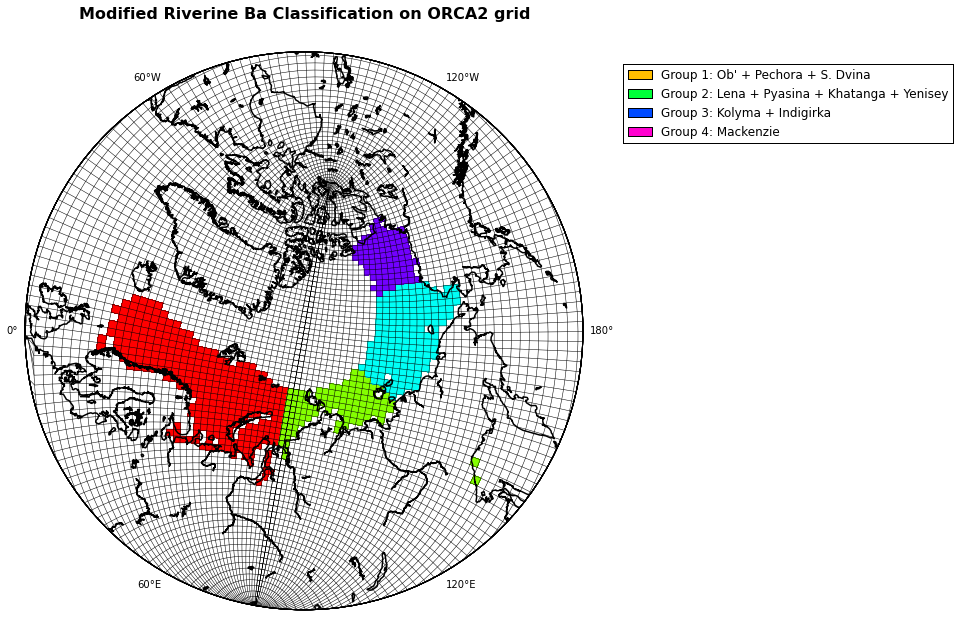

In [43]:
CMap=plt.cm.hsv
var_name='Ba Classification'
clev=[1, 2, 3, 4, 5]
#
fig, ax, proj = Nts.plot_Arctic_LandCover(nav_lon, nav_lat, 50, rf_Ba_interp_masked, clev, regions, CMap, var_name)
#
title='Modified Riverine Ba Classification on ORCA2 grid'
ax.set_title(title, fontsize=16, fontweight='bold', y=1.05)
fig.set_size_inches(10, 10)
#
x, y=proj(nav_lon, nav_lat)
proj.plot(x.T, y.T, color='k', linewidth=0.5)
proj.plot(x, y, color='k', linewidth=0.5)
fig.canvas.draw()

In [44]:
scipy.io.savemat('_data/Exchange/Ba_classif.mat', {'nav_lon': nav_lon, 'nav_lat': nav_lat, 'rf_Ba_group': rf_Ba_group})